<a href="https://colab.research.google.com/github/ssgalitsky/fast-style-transfer/blob/master/ColabWraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ColabWrapper

---
* DeepDream animations for AV1 - live audio/visual performance by "Bevare Owl Drunkens!", pilot episode.
* This colab notebook is a wraper for underlying [DeepDreamAnim by Samim23](https://github.com/samim23/DeepDreamAnim)
---



### 1. Session initialization (should run once at least at start)

> !!! Please read carefully first, fill corresponding values and/or check corresponding checkboxes **before** running initialization step !!!

In [0]:
#@markdown #### 1.1. Kill virtual machine, reset filesystems etc? (**if not sure leave empty**)
killVM = False #@param {type:"boolean"}
if killVM:
  print "Colab session restarting.."
  !kill -9 1  
#@markdown ---




#@markdown #### 1.2. Mount Google Drive (we'll use it as persistant storage for input/output files, test images, checkpoints).

#@markdown



#@markdown ---



#@markdown #### 1.3. Compile Caffe (~15 minutes)? 


compileCaffe = True #@param {type:"boolean"}  

#@markdown ---



#@markdown #### 1.4. Get code & models & training dataset?
#@markdown [Original code](https://github.com/lengstrom/fast-style-transfer) by  Logan Engstrom uses COCO2014 Training Dataset. We'll try more lightweight image collection - COCO2017 Validation Dataset (1GB zip vs 14GB zip).
#@markdown This pretty lifehack was found at [fast-style-transfer-tutorial-pytorch by Lee Hoseong aka Hoya012](https://github.com/hoya012/fast-style-transfer-tutorial-pytorch)
getCodes = True   #@param {type:"boolean"}  
getModel = True   #@param {type:"boolean"}  
getDatas = True #@param {type:"boolean"}  

from google.colab import drive
drive.mount('/gdrive')
 
if compileCaffe:
  print "1.3. ok, starting to build Caffe.."
  print "1.3.1. installing deps and gcc"

  with open('/etc/apt/sources.list') as f:
    txt = f.read()
  with open('/etc/apt/sources.list', 'w') as f:
    f.write(txt.replace('# deb-src','deb-src'))
  t=!apt update
  t=!apt build-dep caffe-cuda
  t=!apt install g++-5

  t=!update-alternatives --remove-all gcc 
  t=!update-alternatives --remove-all g++
  t=!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-5 20
  t=!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-5 20
  t=!update-alternatives --install /usr/bin/cc cc /usr/bin/gcc 30
  t=!update-alternatives --set cc /usr/bin/gcc
  t=!update-alternatives --install /usr/bin/c++ c++ /usr/bin/g++ 30
  t=!update-alternatives --set c++ /usr/bin/g++

  print "1.3.2. downloading & installing boost library (version 1.67.0).."
  t=!wget https://dl.bintray.com/boostorg/release/1.67.0/source/boost_1_67_0.tar.bz2
  t=!tar --bzip2 -xf boost_1_67_0.tar.bz2
  
  print "1.3.3. starting boost library compilation.."
  t=!cd boost_1_67_0 && ./bootstrap.sh --exec-prefix=/usr/local --with-libraries=system,filesystem,regex,thread,python \
    --with-python-version=2.7 --with-python-root=/usr
  t=!cd boost_1_67_0 && ./b2 install

  print "...............................boost compiled!"
  print "1.3.4. downloading SSD-Caffe and configure it"
  t=!git clone https://github.com/weiliu89/caffe.git && cd caffe && git checkout ssd
  
  with open('./caffe/Makefile.config.example') as f:
    config = f.read()
  comment = ['CUDA_DIR := /usr/local/cuda', 
             'BLAS := open']
  uncomment = ['# CUDA_DIR := /usr', 
               '# BLAS := atlas', 
               '# OPENCV_VERSION := 3', '# WITH_PYTHON_LAYER := 1'] #
  replace = [('INCLUDE_DIRS := $(PYTHON_INCLUDE) /usr/local/include',
              'INCLUDE_DIRS := $(PYTHON_INCLUDE) /usr/local/include /usr/include/hdf5/serial /usr/local/lib/python2.7/dist-packages/numpy/core/include/'), 
             ('LIBRARY_DIRS := $(PYTHON_LIB) /usr/local/lib /usr/lib',
              'LIBRARY_DIRS := $(PYTHON_LIB) /usr/local/lib /usr/lib /usr/lib/x86_64-linux-gnu/hdf5/serial')]
  for c in uncomment:
    config = config.replace(c, c[2:])
  for c in comment:
    config = config.replace(c, '# '+c)
  for c1,c2 in replace:
    config = config.replace(c1, c2)
    
  with open('caffe/Makefile.config', 'w') as f:
    f.write(config)
  with open('caffe/Makefile') as f:
    mfile = f.read()
  with open('caffe/Makefile', 'w') as f:
    f.write(mfile.replace('-isystem','-I'))
  with open('/usr/include/x86_64-linux-gnu/c++/5/bits/c++config.h') as f:
    txt = f.read()
  with open('/usr/include/x86_64-linux-gnu/c++/5/bits/c++config.h', 'w') as f:
    f.write(txt.replace('/* #undef _GLIBCXX_USE_C99_MATH */',
                        '/* #undef _GLIBCXX_USE_C99_MATH */\n#define  _GLIBCXX_USE_C99_MATH  1'))
  print "...............................boost compiled!"
  print "1.3.5. trying to make and install Caffe."
  #t=!cd caffe && make -j8 && make pycaffe && make test -j8 && make distribute
  t=!cd caffe && make -j8 && make pycaffe && make distribute
  print '\n'.join(t[-10:])

  t=!echo /usr/local/lib >> /etc/ld.so.conf && ldconfig
  t=!echo /content/caffe/distribute/lib >> /etc/ld.so.conf && ldconfig

  print "...............................Ok, Caffe done."

if getCodes:
  print "1.4.1. downloading program codes.."
  !rm -Rf /content/fast-style-transfer
  !git clone https://github.com/ssgalitsky/fast-style-transfer.git
  print ".......codes have been downloaded."

if getModel:
  print "1.4.2. downloading model imagenet-vgg-verydeep-19.mat."
  !rm -Rf /content/models
  !mkdir -p /content/models
  !wget -O  /content/models/imagenet-vgg-verydeep-19.mat http://www.vlfeat.org/matconvnet/models/beta16/imagenet-vgg-verydeep-19.mat
  print ".......Ok, model is here."
    #  !wget -O ./data/imagenet-vgg-verydeep-16.mat http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-16.mat


if getDatas:
  print "1.4.3. downloading training dataset."
  !rm -Rf /content/trainset
  !mkdir /content/trainset
  !wget -O /content/val2017.zip http://images.cocodataset.org/zips/val2017.zip
  print "........dataset here, unzipping it. Be patient, it will take a time."
  !unzip /content/val2017.zip -d /content/trainset
  print "finally I did it again"


### Misc helper procedures  
import matplotlib.pyplot as plt
import numpy as np  
def show_image_grid(images, n_images=10, n_rows=3, figsize=(10, 10), randomize=False):
    n_cols = int(np.ceil(n_images / n_rows))

    fig = plt.figure(figsize=figsize)

    for i in range(n_images):
        rnd = i
        if randomize:
            rnd = np.random.randint(0, len(images))
        image = images[rnd]
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        ax.imshow(image)
        ax.set_yticks([])
        ax.set_xticks([])
        
import youtube_dl

def youtubeDownload(url, filename,formats="18"):
    youtube_downloader_params = {"quiet": False, "outtmpl": filename, "format": formats}
    with youtube_dl.YoutubeDL(params=youtube_downloader_params) as ydl:
        ydl.download([url])            

### Processing

#### Train model

##### Training mode arguments

style.py
style.py trains networks that can transfer styles from artwork into images.

Flags

--checkpoint-dir: Directory to save checkpoint in. Required.

--style: Path to style image. Required.

--train-path: Path to training images folder. Default: data/train2014.

--test: Path to content image to test network on at at every checkpoint iteration. Default: no image.

--test-dir: Path to directory to save test images in. Required if --test is passed a value.

--epochs: Epochs to train for. Default: 2.

--batch_size: Batch size for training. Default: 4.

--checkpoint-iterations: Number of iterations to go for between checkpoints. Default: 2000.

--vgg-path: Path to VGG19 network (default). Can pass VGG16 if you want to try out other loss functions. Default: data/imagenet-vgg-verydeep-19.mat.

--content-weight: Weight of content in loss function. Default: 7.5e0.

--style-weight: Weight of style in loss function. Default: 1e2.

--tv-weight: Weight of total variation term in loss function. Default: 2e2.

--learning-rate: Learning rate for optimizer. Default: 1e-3.

--slow: For debugging loss function. Direct optimization on pixels using Gatys' approach. Uses test image as content value, test_dir for saving fully optimized images.

##### Run training

In [0]:
styleUrl="https://live.staticflickr.com/1747/42826167752_7ebf7e114e_b.jpg"
testUrl="https://24smi.org/public/media/2017/10/31/07.jpg"
suffice="fst/clockworks4"


batch_size = 4
#random_seed = 10
num_epochs = 1 
initial_lr = 1e-3
initial_lr = 1e-2

content_weight = 1e9
style_weight = 1e6
checkpoint_iterations = 10





In [0]:
!mkdir -p /gdrive/My\ Drive/{suffice}/checkpoint /gdrive/My\ Drive/{suffice}/test

--2019-05-09 11:15:20--  https://live.staticflickr.com/1747/42826167752_7ebf7e114e_b.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 99.84.252.6, 2600:9000:2041:1a00:0:5a51:64c9:c681, 2600:9000:2041:2800:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|99.84.252.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 315791 (308K) [image/jpeg]
Saving to: ‘/gdrive/My Drive/fst/clockworks4/style.jpg’

/gdrive/My Drive/fs 100%[===================>] 308.39K  --.-KB/s    in 0.04s   

2019-05-09 11:15:21 (6.98 MB/s) - ‘/gdrive/My Drive/fst/clockworks4/style.jpg’ saved [315791/315791]

--2019-05-09 11:15:22--  https://24smi.org/public/media/2017/10/31/07.jpg
Resolving 24smi.org (24smi.org)... 37.48.106.245
Connecting to 24smi.org (24smi.org)|37.48.106.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223136 (218K) [image/jpeg]
Saving to: ‘/gdrive/My Drive/fst/clockworks4/test.jpg’

/gdrive/My Drive

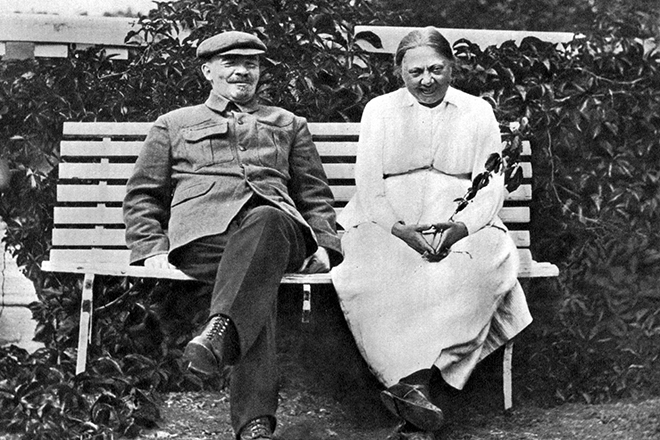

style image:


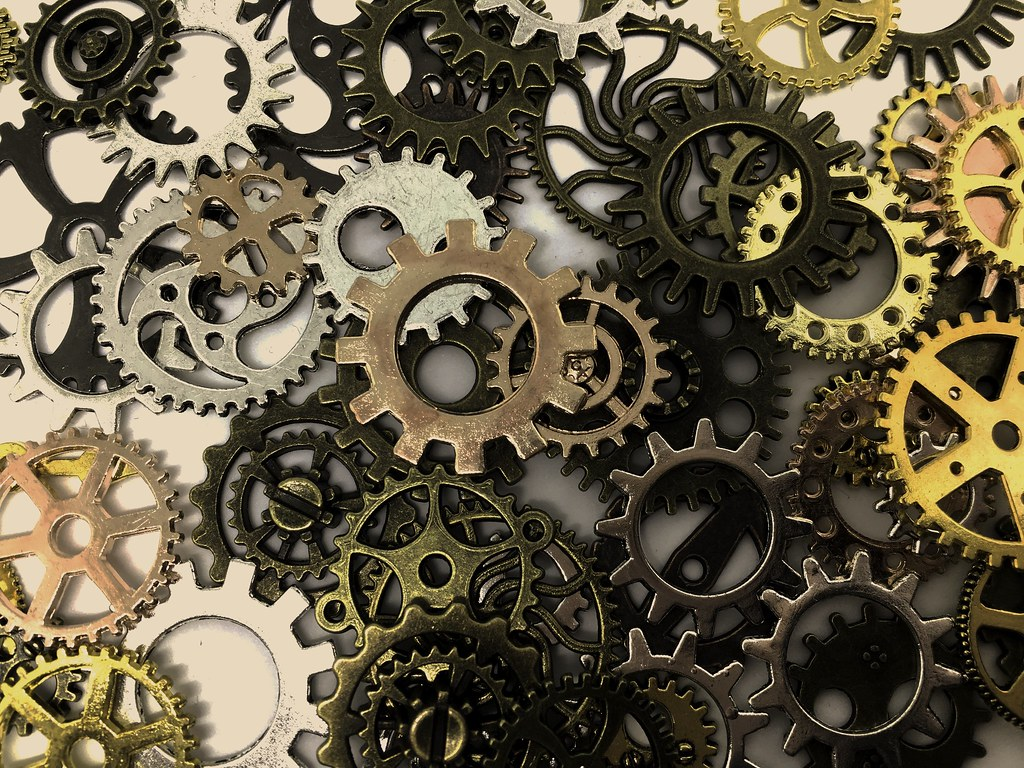

In [0]:
!wget {styleUrl} -O /gdrive/My\ Drive/{suffice}/style.jpg
!wget {testUrl} -O /gdrive/My\ Drive/{suffice}/test.jpg

from google.colab.patches import cv2_imshow
import cv2
print("test image:")
img = cv2.imread("/gdrive/My Drive/%s/test.jpg" % (suffice,), cv2.IMREAD_UNCHANGED)
cv2_imshow(img)
print("style image:")
img = cv2.imread("/gdrive/My Drive/%s/style.jpg" % (suffice,), cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

In [0]:
initial_lr=1e-2
!python style.py --style /gdrive/My\ Drive/{suffice}/style.jpg \
  --epochs {num_epochs} \
  --train-path ./data/bin/val2017 \
  --checkpoint-dir /gdrive/My\ Drive/{suffice}/checkpoint \
  --test /gdrive/My\ Drive/{suffice}/test.jpg \
  --test-dir /gdrive/My\ Drive/{suffice}/test  \
  --content-weight {content_weight} \
  --style-weight {style_weight} \
  --checkpoint-iterations {checkpoint_iterations} \
  --batch-size {batch_size} \
  --learning-rate {initial_lr}

In [0]:
!python style.py --style /gdrive/My\ Drive/{suffice}/style.jpg \
  --epochs {num_epochs} \
  --train-path ./data/bin/val2017 \
  --vgg-path ./data/imagenet-vgg-verydeep-16.mat \
  --checkpoint-dir /gdrive/My\ Drive/{suffice}/checkpoint \
  --test /gdrive/My\ Drive/{suffice}/test.jpg \
  --test-dir /gdrive/My\ Drive/{suffice}/test  \
  --content-weight {content_weight} \
  --style-weight {style_weight} \
  --checkpoint-iterations {checkpoint_iterations} \
  --batch-size {batch_size} \
  --learning-rate {initial_lr}

(1, 768, 1024, 3)
2019-05-09 11:16:32.765978: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-05-09 11:16:32.766228: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x564595b69760 executing computations on platform Host. Devices:
2019-05-09 11:16:32.766259: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-05-09 11:16:32.966136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-05-09 11:16:32.966696: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x564595b69340 executing computations on platform CUDA. Devices:
2019-05-09 11:16:32.966729: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2019-05-09 11:16:32.967147: I tensorflow/core/common_runtime/gpu/

#### Stylize video

##### Download youtube video 

In [0]:
lenin1="https://www.youtube.com/watch?v=qB39bMYnuU4"
youtubeDownload(lenin1, "/gdrive/My Drive/%s/video_in.mp4" % (suffice,),formats="18")

[youtube] qB39bMYnuU4: Downloading webpage
[youtube] qB39bMYnuU4: Downloading video info webpage


[youtube] qB39bMYnuU4: Downloading MPD manifest


[download] Destination: /gdrive/My Drive/fst/clockworks3/video_in.mp4
[download] 100% of 1.62MiB in 00:00


##### Stylize parameters info


--checkpoint-dir: Directory or ckpt file to load checkpoint from. Required.

--in-path: Path to video to transfer style to. Required.

--out-path: Path to out video. Required.

--tmp-dir: Directory to put temporary processing files in. Will generate a dir if you do not pass it a path. Will delete tmpdir afterwards. Default: randomly generates invisible dir, then deletes it after execution completion.

--device: Device to evaluate frames with. Default: /gpu:0.

--batch-size: Batch size for evaluating images. Default: 4.

##### Run stylize on downloaded video file

In [0]:
!python transform_video.py --in-path /gdrive/My\ Drive/{suffice}/video_in.mp4 \
  --checkpoint /gdrive/My\ Drive/{suffice}/checkpoint \
  --out-path /gdrive/My\ Drive/{suffice}/video_out.mp4 \
  --device /gpu:0 \
  --batch-size 4
